In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [5]:
# Dropout 증가 + L2 + Dense 노드 축소
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Dense 노드 축소 + 정규화
    Dropout(0.4),  # Dropout 증가
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, verbose=1)

Epoch 1/20
1200/1200 [==============================] - 80s 61ms/step - loss: 0.4194 - accuracy: 0.8850 - val_loss: 0.4558 - val_accuracy: 0.8749
Epoch 2/20
1200/1200 [==============================] - 72s 60ms/step - loss: 0.2674 - accuracy: 0.9324 - val_loss: 0.9881 - val_accuracy: 0.4990
Epoch 3/20
1200/1200 [==============================] - 72s 60ms/step - loss: 0.2235 - accuracy: 0.9534 - val_loss: 0.3920 - val_accuracy: 0.8701
Epoch 4/20
1200/1200 [==============================] - 71s 59ms/step - loss: 0.1869 - accuracy: 0.9639 - val_loss: 2.7256 - val_accuracy: 0.5640
Epoch 5/20
1200/1200 [==============================] - 71s 59ms/step - loss: 0.1899 - accuracy: 0.9668 - val_loss: 0.3345 - val_accuracy: 0.9089
Epoch 6/20
1200/1200 [==============================] - 71s 59ms/step - loss: 0.1775 - accuracy: 0.9711 - val_loss: 0.3137 - val_accuracy: 0.9096
Epoch 7/20
1200/1200 [==============================] - 71s 59ms/step - loss: 0.1668 - accuracy: 0.9735 - val_loss: 0.3298 -

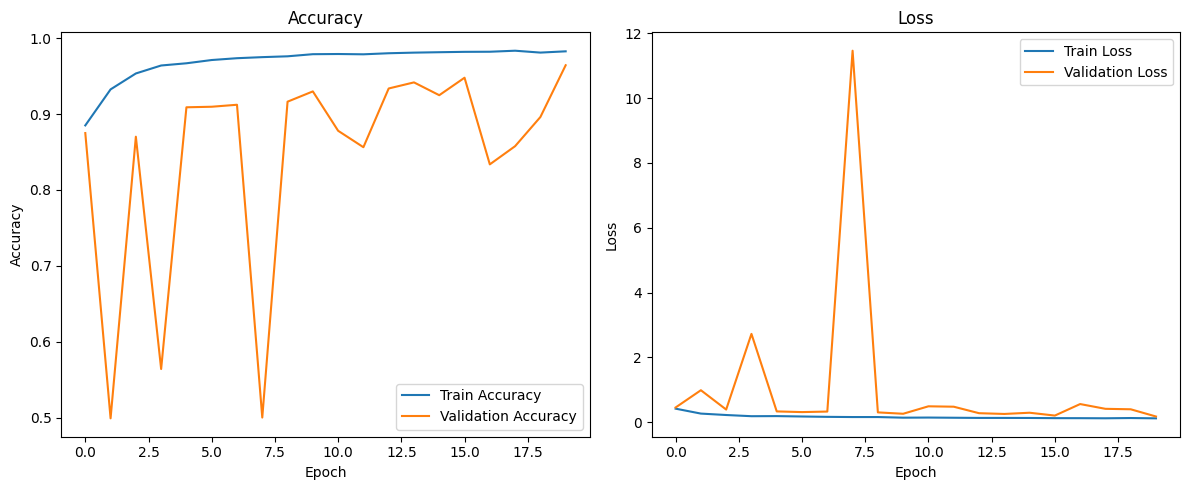

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.96      0.97      0.97      4800
        open       0.97      0.96      0.97      4800

    accuracy                           0.97      9600
   macro avg       0.97      0.97      0.97      9600
weighted avg       0.97      0.97      0.97      9600



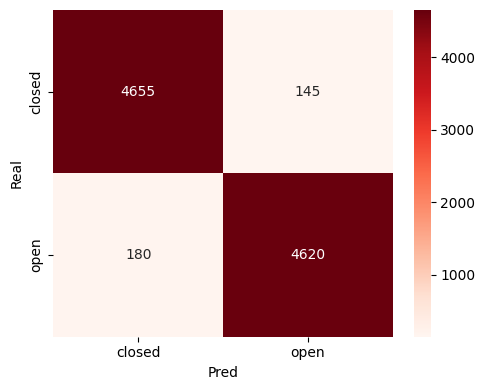

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/02_readjusted_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_confusion_matrix.png")
plt.show()

In [9]:
os.makedirs("../../src/models/05_Readjust_Model", exist_ok=True)
model.save("../../src/models/05_Readjust_Model/readjusted_model.keras")

- Val acc: 96.43  
- classification report acc: 97.00  
- Precision/Recall: 0.96~0.97  
- conf_matrix: FN 180, FP 145  
- Val loss min: 0.1775  
- 그래프:  
  - 진동: 일부 튐 -> 최종 수렴으로 안정적  
    튀는 이유는 generator 또는 batch 구성 이슈일 가능성  
    -> validation_generator.samples가 batch_size * steps 보다 부족한 경우 발생함  
  - Epoch 8에서 튀었지만 빠르게 회복 -> Regularization, Dropout 작용  
  - 마지막 Epoch에서 val loss min값 도출  

- 다음 진행:
  - 이 모델을 baseline으로 이후  
  - dropout 위치 다양화  
  - Conv Layer 추가해보기  